In [6]:
# imports:
import numpy as np
import math, os, pickle
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plt

import statistics


In [7]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def softmax(A):  
    expA = np.exp(A)
    return expA / expA.sum()

def load_objects(file):
    with open(file, 'rb') as input:
        return pickle.load(input)

# functions to use:
def sigmoid(matrix):
    #print("SIGMOID: \n" +str(matrix)+"\n")
    return 1/(1+np.exp(-matrix))

def getInputs(inputs):
    #add bias to layerOne and inputs
    row = inputs.shape[0] if np.ndim(inputs) != 1 else 1
    inputBias = np.ones((row,1)) if np.ndim(inputs) != 1 else np.ones((1))
    inputsWithBias = np.append(inputBias, inputs, 1) if np.ndim(inputs) != 1 else np.append(inputBias, inputs) 
    return inputsWithBias

def networkError(target, netResult):
    print("Target: " + str(target) + " Net Result: " + str(netResult))
    return .5*np.square(target - netResult)

def learning(weights, lr, error, activationsForLayer):
    print("Weights:  " + str(weights.shape))
    print("Learning Rate:  " + str(lr))
    print("Error:  " + str(error.shape))
    print("Activations: "+str(activationsForLayer.shape))
    return weights+lr*error*activationsForLayer

def hiddenUnitError(temp, activations, error):
    return temp*(1-temp)*(activations*error)

def outputError(target, output):
    # Eouput = output(1-output)(target - output)
    return output*(1-output)*(target - output)

def save_it_all(obj, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def saveNet(theta1, theta2, fileName):
    weights = {"theta1":theta1, "theta2":theta2}
    save_it_all(weights, fileName)
    
def sigmoidDerivative(target, output):
    #E = (t − y) * y *  (1− y) // note: derivative of sigmoid func
    return (target - output) * output * (1 - output)

def netPlot(instance, error):
    instance = list(range(0, instance))

    with plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'}):
        fig, ax = plt.subplots()
        ax.plot(instance, error)

        ax.set(xlabel='instance numebr (s)', ylabel='error (net)',
               title='Average Net Error for each batch run')
        ax.grid()

    plt.show()
    
def load_objects(file):
    with open(file, 'rb') as input:
        return pickle.load(input)
    
def classifyFish(inputInstance, theta1, theta2):
    # just need to feed forward 
    layerOneActivations = theta1.dot(np.transpose(inputInstance))
    print("\t\tLayer One activations: \n"+str(layerOneActivations)+"\n")
    layerOneSig = sigmoid(layerOneActivations)
    print("\t\tSigmoid Result: "+ str(layerOneSig) + "\n")
    inputsforhiddenlayer = getInputs(np.transpose(layerOneSig)) 
    print("\t\tInputs for the hiden layer is: (b,h1,h2)\n"+str(inputsforhiddenlayer)+"\n")

    outputActivation = theta2.dot(np.transpose(inputsforhiddenlayer)) 
    print("\t\tActivation for output layer: (h1,h2)\n" + str(outputActivation)+"\n")
        # inplace of sigmoid use softmax?? http://dataaspirant.com/2017/03/07/difference-between-softmax-function-and-sigmoid-function/
    outputFinal = sigmoid(outputActivation)
    print("\t\tFinal output: \n"+ str(outputFinal)+"\n")
    
    return "Yes" if outputFinal >= .5 else "No"


def getArrayFromFile(name):
    array = genfromtxt(name, delimiter=',')
    return array

In [8]:
# neural Net function:
def nn(learningRate, theta1, theta2, inputInstance, targetInstance):
    
    # feed forward:
    layerOneActivations = theta1.dot(np.transpose(inputInstance))
    print("\t\tLayer One activations: \n"+str(layerOneActivations.shape)+"\n")
    layerOneSig = sigmoid(layerOneActivations)
    print("\t\tSigmoid Result: "+ str(layerOneSig.shape) + "\n")
    inputsforhiddenlayer = getInputs(np.transpose(layerOneSig)) 
    print("\t\tInputs for the hiden layer is: (b,h1,h2)\n"+str(inputsforhiddenlayer.shape)+"\n")

    outputActivation = theta2.dot(np.transpose(inputsforhiddenlayer)) 
    print("\t\tActivation for output layer: (h1,h2)\n" + str(outputActivation.shape)+"\n")
        # inplace of sigmoid use softmax?? http://dataaspirant.com/2017/03/07/difference-between-softmax-function-and-sigmoid-function/
    outputFinal = sigmoid(outputActivation)
    print("\t\tFinal output: \n"+ str(outputFinal.shape)+"\n")

    # network error:
    netError = networkError(targetInstance, outputFinal)
    print("\t\tNetwork Error: \n" + str(netError.shape)+"\n")

    # BACKPROPAGATE
    outputErr = outputError(targetInstance, outputFinal[0])
    print("\t\tOutput Error: \n"+str(outputErr.shape)+"\n")

    hidUnitErr = hiddenUnitError(layerOneSig, layerOneActivations, outputErr)
    print("\t\tHidden unit errors: \n"+str(hidUnitErr.shape)+"\n")

    # learning:
    theta1 = learning(theta1, learningRate, hidUnitErr, inputInstance)
    print("\t\tNext round of weights for layerOne: (b,x1,x2) \n"+ str(theta1.shape)+"\n")

    theta2 = learning(theta2, learningRate, outputErr, inputsforhiddenlayer)
    print("\t\tNext round of weights for layer 2: (b,h1,h2) \n"+ str(theta2.shape)+"\n")
    
    return theta1, theta2, netError


In [9]:
#Main:

# load in fishing normalized set 
data = getArrayFromFile("normalizeFish.csv")
inputs = data[:,0:8] # get the input values
targets = data[:, 8:9] # get the class values

inputsWB = getInputs(inputs) # adds bias to the input matrix

numInputNodes = inputsWB.shape[1]
numOutputNodes = 1 if np.unique(targets).shape[0] == 2 else np.unique(targets).shape[0]
numHiddenNodes = int((2/3)*(numInputNodes+numOutputNodes)) # + 1 for the bias node

print("Input nodes with bias node: " + str(numInputNodes))
print("Output layer: " + str(numOutputNodes))
print("Hidden nodes with bias node: " + str(numHiddenNodes))

# inititlize weights
# (-1/sqrt(n)) < w < (1/sqrt(n))
lowRange = (-1/math.sqrt(numInputNodes))
highRange = math.fabs(lowRange)
theta1 = np.random.uniform(low=lowRange, high=highRange, size=(numHiddenNodes, numInputNodes))
theta2 = np.random.uniform(low=lowRange, high=highRange, size=(numOutputNodes,numHiddenNodes+1))

print("Theta1 dims: " + str(theta1.shape))
print("Theta2 dims: " + str(theta2.shape))


learningRate = .5
numberProcess = 0
batchError = []
for r in range(0, 100): # batch
    trackedNetError= []
    
    for index in range(0, inputsWB.shape[0]): # online
        print(color.CYAN+color.BOLD+"----------- Data for batch: "+str(r)+" Online Round: "+str(index)+" ------------"+color.END)
        print("Inputs: \n" + str(inputs[index])+"\n")
        print("Learning Rate: \n" + str(learningRate)+"\n")
        print("Theta One: \n" + str(theta1)+"\n")
        print("Theta two: \n" + str(theta2)+"\n")
        print("Target: \n"+ str(targets[index]) + "\n")
        print(color.YELLOW+color.BOLD+"----------Processing on batch:"+str(r)+" with online instance: "+str(index)+"-------------"+color.END)
        theta1, theta2, netError = nn(learningRate, theta1, theta2, np.array([inputsWB[index]]), targets[index])
        trackedNetError.append(netError[0][0])
    numberProcess = numberProcess + 1 
    batchError.append(statistics.mean(trackedNetError))
saveNet(theta1, theta2, "./FishWeights.pkl")


Input nodes with bias node: 9
Output layer: 1
Hidden nodes with bias node: 6
Theta1 dims: (6, 9)
Theta2 dims: (1, 7)
----------- Data for batch: 0 Online Round: 0 ------------
Inputs: 
[0. 1. 0. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[-0.01306623 -0.17440084  0.23758615  0.00518256 -0.17724083 -0.01192858
   0.32362298 -0.23150995 -0.10746475]
 [ 0.03610596  0.26389185 -0.29820874 -0.27908089  0.16165717 -0.24549854
   0.24131713  0.10477724  0.23597296]
 [ 0.14644086  0.15028363  0.07565064 -0.12741461 -0.32996057  0.17292466
  -0.04066798 -0.23382776 -0.26329298]
 [-0.10890531 -0.17328075  0.09878108 -0.01090153 -0.22945802  0.2377974
   0.086447    0.33283112  0.11644475]
 [-0.13349162  0.04485081 -0.31915481 -0.17887167 -0.14277587  0.00692084
  -0.02249693 -0.18527829  0.10948275]
 [ 0.21237596 -0.04542637  0.31645868 -0.13221656 -0.08894038 -0.23289226
  -0.00735144  0.29885146 -0.12948024]]

Theta two: 
[[-0.30042929  0.30308467 -0.00480782  0.00517327 -0.31067472  0

Target: [1.] Net Result: [[0.56173186]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 3 Online Round: 3 ------------
Inputs: 
[0. 0. 1. 0. 0. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.09608083 -0.16309703  0.26306777  0.05330683 -0.14169965  0.05874672
   0.39595251 -0.2279475  -0.07420968]
 [-0.03275553  0.21586998 -0.33813881 -0.27339589  0.12704075 -0.28049735
   0.2040409   0.09208644  0.2170785 ]
 [ 0.17229841  0.14702931  0.07661367 -0.11175043 -0.32073024  0.2131238
  -0.02641947 -0.23388743 -0.25162428]
 [-0.06183826 -0.1549818   0.1425932  -0.01866915 -0.21843546  0.25268088
   0.11284614  0.35445912  0.11548467]
 [-0.2082876   0.07904321 -0.37120913 -0.21511

Target: [0.] Net Result: [[0.54942977]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 6 Online Round: 7 ------------
Inputs: 
[0. 0. 1. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.18115964 -0.17505453  0.28495239  0.11270317 -0.13790181  0.09723229
   0.47060801 -0.21995804 -0.07177584]
 [-0.09225874  0.185334   -0.37211888 -0.27686554  0.10498726 -0.30688734
   0.15702143  0.07916541  0.21751578]
 [ 0.19110046  0.1351569   0.07930191 -0.09499257 -0.32137428  0.24169242
  -0.01079198 -0.23263703 -0.2497001 ]
 [-0.02636904 -0.14674687  0.17793225 -0.02054765 -0.21642681  0.26048476
   0.14225634  0.37237159  0.10363121]
 [-0.26322535  0.12181391 -0.40989284 -0.2613


Theta two: 
[[-0.23917907  0.65450965 -0.15622585  0.10541141 -0.15571124 -0.17299168
   0.1931994 ]]

Target: 
[1.]

----------Processing on batch:9 with online instance: 10-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.55074516]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 9 Online Round: 11 ------------
Inputs: 
[1. 0. 1. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.28793252 -0.18781058  0.30927357  0.19426778 -0.13701471  0.13536171
   0.59818705 -0.20764119 -0.10489884]
 [-0.148998

Theta two: 
[[-0.22592207  0.80799196 -0.23132656  0.1581691  -0.08470072 -0.30540592
   0.29860143]]

Target: 
[1.]

----------Processing on batch:13 with online instance: 0-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.63558531]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 13 Online Round: 1 ------------
Inputs: 
[1. 1. 0. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 3.94544028e-01 -2.14055114e-01  3.52362132e-01  2.72251565e-01
  -1.51475559e-01  1.61230767e-01  7.33598284e-01 -1.911900

Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 16 Online Round: 4 ------------
Inputs: 
[0. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 4.69604774e-01 -2.69445365e-01  3.66237066e-01  3.51631288e-01
  -1.69669469e-01  1.68916766e-01  8.21011551e-01 -1.63623895e-01
  -1.90068382e-01]
 [-2.92572093e-01  1.92609345e-01 -4.92142131e-01 -3.60710376e-01
   1.08541992e-01 -3.51449870e-01 -7.03150786e-02  1.16977631e-02
   3.12006592e-01]
 [ 2.86087703e-01  9.02736966e-02  9.89998354e-02 -3.42644901e-04
  -3.40734896e-01  3.22336155e-01  1.18960283e-01 -2.19711745e-01
  -2.97390416e-01]
 [ 1.33440748e-01 -1.73722246e-01  3.05064073e-01  2.69346887e-02
  -2.31231178e-01  2.90114855e-01  2.95917143e-01  4.51790323e-01
   3.03614647e-02]
 [-5.53514940e-01  2.47938579e-01 -5.42543918e-01 -4.71527922e-01
  -4.67538280e-02 -3.75562797e-02 -4.81240413e-01 -3.60599001e-01
   3.23523618e-01]
 [ 6.06705118e-01 -2.29642360e-01  5.393

Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 19 Online Round: 9 ------------
Inputs: 
[0. 0. 1. 0. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.54519032 -0.32746584  0.38753238  0.43171078 -0.19545873  0.16231811
   0.92379725 -0.13959859 -0.24129384]
 [-0.36718656  0.22261482 -0.52517231 -0.41786942  0.12411674 -0.35360862
  -0.16420725 -0.0148896   0.35787166]
 [ 0.32552935  0.05914276  0.10638959  0.04570617 -0.35473182  0.33714463
   0.17619714 -0.2125     -0.32239736]
 [ 0.19581009 -0.2014669   0.34150431  0.06788475 -0.24625213  0.29236712
   0.36571228  0.48064392 -0.00591792]
 [-0.63660551  0.30942912 -0.57490744 -0.5509671  -0.0180417  -0.03019889
  -0.58724239 -0.39458458  0.3804206 ]
 [ 0.68844554 -0.28168298  0.57308122  0.09134193 -0.09305182 -0.10759375
   0.29684154  0.52389972 -0.18265191]]

Theta two: 
[[-0.40104735  0.99675422 -0.49570984  0.14549738 -0.02876332 -0.68818

Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 22 Online Round: 13 ------------
Inputs: 
[1. 0. 1. 0. 0. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.6178155  -0.35587392  0.41176985  0.4987535  -0.21411374  0.15878927
   1.02800548 -0.11354671 -0.29892877]
 [-0.44800129  0.23420547 -0.56100128 -0.47687897  0.13814054 -0.35913485
  -0.27241312 -0.0434121   0.4137853 ]
 [ 0.38074659  0.04974719  0.11937137  0.09933226 -0.36612245  0.3602623
   0.25751699 -0.20355796 -0.35744202]
 [ 0.26894472 -0.21421167  0.38105412  0.11462193 -0.2594045   0.30071972
   0.45282946  0.51090988 -0.05016644]
 [-0.71779317  0.34034526 -0.60776993 -0.61976125  0.00242729 -0.02885368
  -0.69654176 -0.4278602   0.44180793]
 [ 0.77494018 -0.31093089  0.60768845  0.15826107 -0.10808355 -0.09855355
   0.39639936  0.55642643 -0.22824179]]

Theta two: 
[[-0.43825203  1.13902    -0.62495413  0.19280853  0.04412854 -0.87595


		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 26 Online Round: 3 ------------
Inputs: 
[0. 0. 1. 0. 0. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.65887731 -0.43173724  0.42574296  0.54333558 -0.23160712  0.14564962
   1.07992712 -0.07694561 -0.34638969]
 [-0.50725509  0.29040558 -0.5865281  -0.52540103  0.15293561 -0.3541081
  -0.34025192 -0.08308398  0.46204218]
 [ 0.4130326   0.00351166  0.12097309  0.1417474  -0.3778533   0.3701648
   0.30852707 -0.18909775 -0.39062631]
 [ 0.33001369 -0.26170397  0.41162854  0.15920222 -0.27349023  0.29974558
   0.51142961  0.55222263 -0.08901036]
 [-0.76461545  0.41945273 -0.62862423 -0.66469591  0.02139396 -0.01737133
  -0.75370142 -0.47036585  0.49465097


Theta two: 
[[-0.71331268  1.24872761 -0.95580261  0.1503841   0.07641891 -1.28926168
   0.64595506]]

Target: 
[0.]

----------Processing on batch:29 with online instance: 6-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.55749045]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 29 Online Round: 7 ------------
Inputs: 
[0. 0. 1. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.69472221 -0.49865086  0.43679098  0.60014982 -0.26362448  0.11303036
   1.1129833  -0.04895991 -0.37158668]
 [-0.555688

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.57093262]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 32 Online Round: 10 ------------
Inputs: 
[1. 0. 1. 0. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.73119184 -0.5541347   0.44454591  0.63362606 -0.26838601  0.08927477
   1.16541097 -0.02112777 -0.41537686]
 [-0.60704462  0.38772493 -0.61886902 -0.62616866  0.18625463 -0.31236103
  -0.46590939 -0.14261934  0.54744548]
 [ 0.48058828 -0.07934398  0.12672669  0.23057422 -0.40487803  0.36310424
   0.41661098 -0.16318038 -0.4570719 ]
 [ 0.43298117 -0.34647426  0.45011746  0.25667987 -0.30648932  0.26945128
   0.63191


Target: 
[0.]

----------Processing on batch:35 with online instance: 13-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.41652623]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 36 Online Round: 0 ------------
Inputs: 
[0. 1. 0. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.77169258 -0.60069368  0.45250662  0.68049222 -0.28271215  0.07843454
   1.20945306  0.00613589 -0.44618187]
 [-0.66236814  0.42276037 -0.63234099 -0.68075552  0.19898995 -0.30871707
  -0.52964652 -0.17124458  0.58448433]


Target: [1.] Net Result: [[0.52347989]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 39 Online Round: 4 ------------
Inputs: 
[0. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.80232213 -0.67302278  0.44989485  0.72704257 -0.29602118  0.05424831
   1.21487509  0.04112054 -0.45595901]
 [-0.70245636  0.48702523 -0.63446468 -0.730129    0.21039891 -0.28995577
  -0.55214529 -0.20754904  0.60319934]
 [ 0.55162435 -0.16132936  0.12306843  0.32636795 -0.42597745  0.36767012
   0.50539995 -0.12970598 -0.50829921]
 [ 0.53575603 -0.43404715  0.47037678  0.36386888 -0.3311628   0.25630884
   0.72296876  0.67821588 -0.22080043]
 [-0.91648506  0.6635744  -0.65630767 -0.854


Theta two: 
[[-1.07659056  1.47723785 -1.4842176   0.15577507  0.21016738 -1.93303802
   0.87158904]]

Target: 
[1.]

----------Processing on batch:42 with online instance: 7-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.75322733]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 42 Online Round: 8 ------------
Inputs: 
[0. 0. 0. 1. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.81144756 -0.74075674  0.44691741  0.76363793 -0.32051367  0.01712237
   1.21745513  0.06612642 -0.47441948]
 [-0.722707


Target: 
[1.]

----------Processing on batch:45 with online instance: 12-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.80103404]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 45 Online Round: 13 ------------
Inputs: 
[1. 0. 1. 0. 0. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.83714425 -0.78126861  0.44374899  0.79304488 -0.3210555  -0.0024191
   1.2508825   0.09000296 -0.5060267 ]
 [-0.7570829   0.57814322 -0.63479662 -0.80447549  0.23045079 -0.24404071
  -0.6206769  -0.25753944  0.66709481]



Theta two: 
[[-1.21359911  1.57736367 -1.6971426   0.17649349  0.2750266  -2.18845688
   0.96567316]]

Target: 
[1.]

----------Processing on batch:49 with online instance: 2-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.68992885]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 49 Online Round: 3 ------------
Inputs: 
[0. 0. 1. 0. 0. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.84193836 -0.85167411  0.42886957  0.81998371 -0.3283208  -0.02526637
   1.2435794   0.12009329 -0.52401983]
 [-0.768751


Learning Rate: 
0.5

Theta One: 
[[ 0.86643615 -0.90012308  0.41691712  0.86090867 -0.33279552 -0.0463014
   1.24815192  0.14141666 -0.52541793]
 [-0.79664584  0.68503629 -0.61350238 -0.87384936  0.23896747 -0.20636111
  -0.6406843  -0.30933501  0.69933483]
 [ 0.62583493 -0.33151694  0.08848399  0.46505805 -0.45587252  0.32818951
   0.61202064 -0.06856293 -0.60185236]
 [ 0.64302572 -0.615399    0.45364146  0.51842729 -0.3617162   0.18803459
   0.82639738  0.77855441 -0.3172979 ]
 [-0.97890667  0.88845189 -0.6152003  -0.99109025  0.12007315  0.15340774
  -0.95837347 -0.6790669   0.69373285]
 [ 1.11529747 -0.79271467  0.6098621   0.60163053 -0.21326937 -0.21730447
   0.75938938  0.79028052 -0.48472861]]

Theta two: 
[[-1.19451342  1.68164097 -1.77150351  0.23284753  0.36277553 -2.28664748
   1.07299655]]

Target: 
[0.]

----------Processing on batch:52 with online instance: 6-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,

----------Processing on batch:55 with online instance: 9-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.58565988]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 55 Online Round: 10 ------------
Inputs: 
[1. 0. 1. 0. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.86346996 -0.95493416  0.40279751  0.875286   -0.33601944 -0.08194635
   1.25313497  0.16175603 -0.55370653]
 [-0.79939794  0.73396046 -0.60173438 -0.88935437  0.23995238 -0.17386679
  -0.6564784  -0.32964483  0.73268666]
 [ 0.6270658  -0

Target: [1.] Net Result: [[0.82518955]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 59 Online Round: 1 ------------
Inputs: 
[1. 1. 0. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.88859148 -0.98727748  0.39123201  0.91150101 -0.33554742 -0.0908987
   1.27315461  0.1811965  -0.56804513]
 [-0.82915787  0.7612989  -0.59309171 -0.92632466  0.23852008 -0.16708263
  -0.68581346 -0.3489791   0.75159606]
 [ 0.65502286 -0.39629734  0.06880931  0.51878369 -0.46073555  0.30557509
   0.66701544 -0.04268641 -0.65353575]
 [ 0.6810102  -0.68645729  0.43444616  0.57604058 -0.3621497   0.1551338
   0.87739795  0.81721365 -0.36897322]
 [-0.99977092  0.9743599  -0.58500548 -1.04251


Theta two: 
[[-1.39821057  1.7734874  -2.04129249  0.23151451  0.41709174 -2.60776351
   1.16125916]]

Target: 
[1.]

----------Processing on batch:62 with online instance: 3-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.55819048]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 62 Online Round: 4 ------------
Inputs: 
[0. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.89937485 -1.04386299  0.36291672  0.94816183 -0.33310959 -0.10753707
   1.25996655  0.20586662 -0.56874382]
 [-0.842021


Theta two: 
[[-1.43576738  1.82107187 -2.11626077  0.24368444  0.44945594 -2.70073946
   1.20773288]]

Target: 
[1.]

----------Processing on batch:65 with online instance: 7-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.85599267]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 65 Online Round: 8 ------------
Inputs: 
[0. 0. 0. 1. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.90335261 -1.08740594  0.34350107  0.97290094 -0.33445529 -0.12850987
   1.25854479  0.22353436 -0.58101204]
 [-0.849045


Learning Rate: 
0.5

Theta One: 
[[ 0.90958612 -1.11614676  0.32308302  0.98635566 -0.32125846 -0.14432696
   1.27557147  0.24056391 -0.60883476]
 [-0.85744765  0.87864981 -0.53231927 -0.99975847  0.22289166 -0.11656949
  -0.709258   -0.40766947  0.80544119]
 [ 0.67409222 -0.49642197  0.01320916  0.58651818 -0.45380053  0.27562564
   0.70739156 -0.00312863 -0.7144003 ]
 [ 0.71270134 -0.79932823  0.37459241  0.65404233 -0.34860657  0.11120546
   0.90682043  0.87418638 -0.42367729]
 [-1.01731522  1.10182924 -0.509173   -1.11921151  0.10375856  0.24004507
  -0.99766316 -0.76499968  0.78054676]
 [ 1.16721913 -0.99268833  0.498287    0.7447873  -0.19292938 -0.28777726
   0.82667433  0.8679652  -0.57777659]]

Theta two: 
[[-1.47776624  1.86207406 -2.18933096  0.26003589  0.47707463 -2.79006594
   1.24497196]]

Target: 
[1.]

----------Processing on batch:68 with online instance: 11-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h


Theta two: 
[[-1.5386422   1.88638618 -2.26885985  0.26019061  0.49237312 -2.88321852
   1.26713215]]

Target: 
[1.]

----------Processing on batch:72 with online instance: 3-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.57604105]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 72 Online Round: 4 ------------
Inputs: 
[0. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.92470027 -1.16198507  0.29477058  1.02269099 -0.31416719 -0.15566848
   1.27080628  0.26237581 -0.61076733]
 [-0.874808


Theta two: 
[[-1.53059804  1.95652433 -2.32146067  0.2999822   0.54862248 -2.95194963
   1.33509712]]

Target: 
[0.]

----------Processing on batch:75 with online instance: 6-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.29079339]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 75 Online Round: 7 ------------
Inputs: 
[0. 0. 1. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.92749294 -1.19699143  0.27306996  1.04280545 -0.30978836 -0.17214151
   1.27053148  0.27812236 -0.6234464 ]
 [-0.879271

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 78 Online Round: 12 ------------
Inputs: 
[0. 1. 0. 0. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.9354373  -1.21597321  0.25126035  1.0574102  -0.29463914 -0.18720883
   1.29152975  0.29338139 -0.65175934]
 [-0.88939696  0.96872962 -0.4688185  -1.06901279  0.19669591 -0.07424119
  -0.74252018 -0.45962113  0.85870572]
 [ 0.70095218 -0.56935304 -0.04064312  0.65022228 -0.4367924   0.25247136
   0.75905738  0.03251108 -0.77484585]
 [ 0.74710566 -0.88672575  0.31174054  0.72714686 -0.3244549   0.07435702
   0.94443669  0.9244703  -0.47717314]
 [-1.0393169   1.20126735 -0.43016449 -1.19193853  0.0754754   0.27814898
  -1.01748132 -0.81067973  0.82404329]
 [ 1.1909199  -1.09016324  0.41451923  0.82337116 -0.16404471 -0.32062979
   0.85421027  0.90937459 -0.62302114]]

Theta two: 
[[-1.58714459  1.9851925  -2.39731484  0.30660072  0


Learning Rate: 
0.5

Theta One: 
[[ 0.9443211  -1.24379098  0.23322492  1.07515504 -0.28546475 -0.19720648
   1.29904965  0.30817678 -0.66519083]
 [-0.90001179  0.99407126 -0.45357341 -1.08599818  0.18782138 -0.06423459
  -0.75475464 -0.47415305  0.87485727]
 [ 0.71098586 -0.58956544 -0.05229026  0.66571307 -0.43060235  0.24840572
   0.77717583  0.04251685 -0.7929364 ]
 [ 0.75845246 -0.91148449  0.29672855  0.74519863 -0.31614789  0.0659337
   0.95783058  0.93852258 -0.49327252]
 [-1.04701695  1.22920037 -0.41017153 -1.21005897  0.06590282  0.28682967
  -1.025929   -0.82352772  0.83763892]
 [ 1.19847209 -1.11832875  0.39293258  0.84278501 -0.15431971 -0.32793367
   0.86407929  0.92106096 -0.63702435]]

Theta two: 
[[-1.61271701  2.02824521 -2.45887386  0.32765014  0.59740948 -3.11727657
   1.40037279]]

Target: 
[0.]

----------Processing on batch:82 with online instance: 1-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,

Target: 
[0.]

----------Processing on batch:85 with online instance: 4-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.07168213]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 85 Online Round: 5 ------------
Inputs: 
[1. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.94980387 -1.28498201  0.20127533  1.10304804 -0.27592539 -0.20902747
   1.28793361  0.32721097 -0.66762621]
 [-0.90653508  1.03233203 -0.42452843 -1.11242919  0.17868413 -0.05219062
  -0.74832632 -0.49284084  0.88059344]
 [


Target: 
[0.]

----------Processing on batch:88 with online instance: 9-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.59136579]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 88 Online Round: 10 ------------
Inputs: 
[1. 0. 1. 0. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.94325582 -1.31118351  0.18071756  1.10446424 -0.26333187 -0.23300584
   1.29636646  0.34098119 -0.69637733]
 [-0.9011871   1.05650886 -0.4062831  -1.11316937  0.16652695 -0.02788054
  -0.76066868 -0.50635616  0.91179911]



Theta two: 
[[-1.73184096  2.11802186 -2.64670333  0.35428559  0.65730157 -3.34486227
   1.48407021]]

Target: 
[0.]

----------Processing on batch:91 with online instance: 13-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [0.] Net Result: [[0.10419615]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 92 Online Round: 0 ------------
Inputs: 
[0. 1. 0. 0. 0. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.95952214 -1.32420386  0.16298894  1.12894629 -0.25381898 -0.23692134
   1.31300587  0.35432699 -0.71009622]
 [-0.91876


Target: 
[1.]

----------Processing on batch:95 with online instance: 3-------------
		Layer One activations: 
(6, 1)

		Sigmoid Result: (6, 1)

		Inputs for the hiden layer is: (b,h1,h2)
(1, 7)

		Activation for output layer: (h1,h2)
(1, 1)

		Final output: 
(1, 1)

Target: [1.] Net Result: [[0.60758139]]
		Network Error: 
(1, 1)

		Output Error: 
(1,)

		Hidden unit errors: 
(6, 1)

Weights:  (6, 9)
Learning Rate:  0.5
Error:  (6, 1)
Activations: (1, 9)
		Next round of weights for layerOne: (b,x1,x2) 
(6, 9)

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 95 Online Round: 4 ------------
Inputs: 
[0. 0. 0. 1. 1. 0. 0. 1.]

Learning Rate: 
0.5

Theta One: 
[[ 0.96641851 -1.35892987  0.13576141  1.1536685  -0.24441729 -0.24893387
   1.30608046  0.37147244 -0.7134199 ]
 [-0.92647307  1.09964457 -0.36627063 -1.16033198  0.14839112 -0.01158762
  -0.77816173 -0.53626949  0.93391952]
 

Weights:  (1, 7)
Learning Rate:  0.5
Error:  (1,)
Activations: (1, 7)
		Next round of weights for layer 2: (b,h1,h2) 
(1, 7)

----------- Data for batch: 98 Online Round: 8 ------------
Inputs: 
[0. 0. 0. 1. 1. 1. 0. 0.]

Learning Rate: 
0.5

Theta One: 
[[ 0.97010779 -1.3796208   0.11795187  1.16747458 -0.23672455 -0.26259824
   1.31111806  0.38385325 -0.72714901]
 [-0.93071653  1.11887576 -0.35035659 -1.17339763  0.14129926  0.00252064
  -0.78608717 -0.54840882  0.94974083]
 [ 0.73135003 -0.69097719 -0.13894131  0.7400627  -0.39793677  0.21245792
   0.83619757  0.09365847 -0.8827356 ]
 [ 0.7910605  -1.03466269  0.19348377  0.8372573  -0.27235372  0.00667252
   0.99331666  1.01027802 -0.56790599]
 [-1.06772931  1.36472949 -0.28499102 -1.30555225  0.01550324  0.3464919
  -1.04150481 -0.88968704  0.89866169]
 [ 1.21687445 -1.25669806  0.25723938  0.94542006 -0.10285921 -0.38141222
   0.88247628  0.98159327 -0.69755129]]

Theta two: 
[[-1.81213797  2.1716622  -2.76757282  0.36375741  0.6

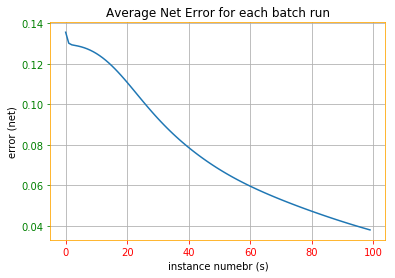

In [10]:
netPlot(numberProcess, batchError)

In [ ]:
# remember for this set you target yes as 1 and no as 0, confusing I know
weightMap = load_objects("./FishWeights.pkl")
theta1 = weightMap["theta1"]
theta2 = weightMap["theta2"]

test = getArrayFromFile("normalizeFishTest.csv")
print(test)
print(test.shape)
test = getInputs(test)

testInstance = test

classifyFish(testInstance, theta1, theta2)
